# Example of UNET module

In [1]:
import os
import time
import numpy as np
import renom as rm
from tqdm import tqdm
import matplotlib.pyplot as plt

from renom_img.api.segmentation.unet import UNet
from renom_img.api.utility.distributor.distributor import ImageDistributor
from renom_img.api.utility.augmentation import Augmentation
from renom_img.api.utility.augmentation.process import *
from renom_img.api.utility.misc.display import draw_segment
from renom_img.api.utility.evaluate import EvaluatorSegmentation

from renom.cuda import set_cuda_active
from PIL import Image
%matplotlib inline

In [2]:
set_cuda_active(True)

In [3]:
# if not os.path.exists("VOCdevkit/VOC2012"):
#     !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#     !tar xfv VOCtrainval_11-May-2012.tar

In [4]:
class_map = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
             'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
             'dog', 'horse', 'motorbike', 'person', 'potted plant', 
             'sheep', 'sofa', 'train', 'tv/monitor', 'void']

prefix_path = '/mnt/data1/jun/dataset/VOCdevkit/VOC2012/'

In [5]:
train_image_path_list = []
train_annotation_path_list = []

with open(os.path.join(prefix_path, 'ImageSets', 'Segmentation', 'train.txt')) as f:
    txt = f.readlines()
    txt = [line.split('\n')[0] for line in txt]
    for i in range(len(txt)):
        train_image_path_list.append(os.path.join(prefix_path, 'JPEGImages', txt[i]+'.jpg'))
        train_annotation_path_list.append(os.path.join(prefix_path, 'SegmentationClass', txt[i]+'.png'))
                                          
valid_image_path_list = []
valid_annotation_path_list = []

with open(os.path.join(prefix_path, 'ImageSets', 'Segmentation', 'val.txt')) as f:
    txt = f.readlines()
    txt = [line.split('\n')[0] for line in txt]
    for i in range(len(txt)):
        valid_image_path_list.append(os.path.join(prefix_path, 'JPEGImages', txt[i]+'.jpg'))
        valid_annotation_path_list.append(os.path.join(prefix_path, 'SegmentationClass', txt[i]+'.png'))
        
print("Dataset size")
print("  Train:{}".format(len(train_image_path_list)))
print("  Valid:{}\n".format(len(valid_image_path_list)))
        

Dataset size
  Train:1464
  Valid:1449



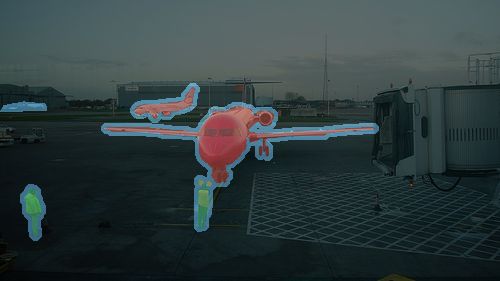

In [6]:
annot = np.array(Image.open(train_annotation_path_list[0]))
draw_segment(train_image_path_list[0], annot, show_background=True)

In [7]:
model = UNet(class_map, imsize=(124, 124), train_whole_network=True)

In [8]:
augmentation = Augmentation([
                Flip(),
                WhiteNoise(),
                ContrastNorm([0.5, 1.0])
            ])

In [ ]:
def callback(epoch, *args):
    image_id = np.random.randint(len(train_image_path_list))
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(draw_segment(train_image_path_list[image_id], model.predict(train_image_path_list[image_id])))
    fig.add_subplot(1, 2, 2)
    annot = np.array(Image.open(train_annotation_path_list[image_id]))
    plt.imshow(draw_segment(train_image_path_list[image_id], annot))
    plt.show()
    model.save('/mnt/data1/jun/checkpoints/unet/model_{}.hdf5'.format(epoch))

model.fit(train_img_path_list=train_image_path_list, train_annotation_list=train_annotation_path_list,
          valid_img_path_list=valid_image_path_list, valid_annotation_list=valid_annotation_path_list, 
          batch_size=32, callback_end_epoch=callback, augmentation=augmentation, epoch=200, class_weight=False)

In [9]:
model.load('/mnt/data1/jun/checkpoints/unet/model_181.hdf5')

In [10]:
results = model.predict(valid_image_path_list)

 99%|█████████▉| 181/182 [00:15<00:00, 12.50it/s]

In [11]:
results = np.array(results)

In [12]:
imsize = (124, 124)
targets = []
for path in valid_annotation_path_list:
    annot = Image.open(path)
    annot.load()
    annot = np.array(annot.resize(imsize))
    for i in range(annot.shape[0]):
        for j in range(annot.shape[1]):
            if annot[i, j] >= len(class_map):
                annot[i, j] = 21
    targets.append(annot)
targets = np.array(targets)            

100%|██████████| 182/182 [00:30<00:00, 12.50it/s]

In [13]:
evaluator = EvaluatorSegmentation(results, targets, ignore_class=[0, 21])

In [14]:
print(evaluator.report())

                  IoU    Precision       Recall     F1 score   #pred/#target 

      1         0.294        0.547        0.388        0.454        67995/175022 
      2         0.043        0.137        0.059        0.082         4037/68947 
      3         0.052        0.099        0.097        0.098        17748/182867 
      4         0.097        0.216        0.149        0.177        17347/116261 
      5         0.026        0.126        0.031        0.050         5240/167276 
      6         0.381        0.619        0.498        0.552       186080/373673 
      7         0.244        0.684        0.276        0.393        87102/316119 
      8         0.220        0.475        0.291        0.361       139268/478740 
      9         0.017        0.140        0.019        0.033         3388/181294 
     10         0.249        0.430        0.371        0.398        94196/254133 
     11         0.087        0.313        0.107        0.159        25850/241934 
     12         0.19